# **1. Image Segmentation**
* 컴퓨터 비전 분야에서 이미지나 비디오의 디지털 데이터를 여러 개의 부분 또는 객체로 분할하는 기술
* 이미지의 중요한 요소들의 식별하고 각 요소를 개별적으로 분석할 수 있게 하는 것

# **2. Image Segmentation의 유형**
* Sementic Segmentation의
  * 이미지의 각 픽셀을 미리 정의된 클래스 레이블 중 하나로 분류
  * 예) 자율 주행자의 도로, 차선, 보행자 등을 식별
* Instance Segmentation
  * 동일한 클래스 내의 서로 다른 개체들을 개별적으로 식별
  * 예) 이미지 내의 있는 개별 문체의 수를 파악하고 각각 물체를 식별 및 추적하는 경우
* Panoptic Segmentation
  * Semantic Segmentation, Instance Segmentation을 결합한 형태
  * 배경과 같은 클래스를 처리하는 Sementic Segmentation과 개체를 구분하는 Instance Segmentation을 모두 수행
  * 예) 풍경 이미지에서 하늘, 도로, 나무와 사람, 자동차를 동시에 식별

https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&dataSetSn=581

# **3. 차량 파손 검사 예제**

In [12]:
import os
import random
import shutil
import cv2
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [13]:
data_root ='/content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation'
file_root = f'{data_root}/data'
cls_list = ['Scratched', 'Breakage', 'Separated', 'Crushed']
project_name = 'cd'

In [4]:
# data_root
# data_root/data
# data_root/cd/train -> images, labels
# data_root/cd/valid -> images, labels
# data_root/cd/test -> images, labels

In [16]:
train_root = f'{data_root}/{project_name}/train'
valid_root = f'{data_root}/{project_name}/valid'
test_root = f'{data_root}/{project_name}/test'

for folder in [train_root, valid_root, test_root]:
    if not os.path.exists(folder):
        os.makedirs(folder)
    for s in ['images', 'labels']:
        s_folder = f'{folder}/{s}'
        if not os.path.exists(s_folder):
            os.makedirs(s_folder)

In [6]:
# 라벨링 형태 변환(YOLO): [cls xc, yc, w, h]
# [[x1, y1], [x2, y2] ... ] -> [cls xc yc w h] : normalize
def json_to_yolo_polygon(polygon, w, h):
    yolo_list = []
    for p in polygon:
        # normalize
        yolo_list.append(p[0]/w)
        yolo_list.append(p[1]/h)
    return " ".join([str(x) for x in yolo_list])

In [7]:
# 데이터 불러오기
file_list = glob.glob(f'{file_root}/annotations/*.json')
random.seed(2024)
random.shuffle(file_list)
print(len(file_list))

1200


In [8]:
file_list[0]

'/content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation/data/annotations/0413509_as-2547434.json'

In [9]:
# 라벨링 형태 변환 파일 생성(json -> txt)
mask_name = file_list[0].split('/')[-1].replace('json', 'txt')
result = []

with open(file_list[0], 'r') as json_file:
    data = json.load(json_file)
    h = data['images']['height']
    w = data['images']['width']
    for ann in data['annotations']:
        label = ann['damage']
        if label in cls_list:
            polygon_cood = ann['segmentation'][0][0][:-1]
            cood_string = json_to_yolo_polygon(polygon_cood, w, h)
            yolo_string = f'{cls_list.index(label)} {cood_string}'
            result.append(yolo_string)

In [10]:
result

['1 0.11375 0.575 0.14875 0.5816666666666667 0.17625 0.5916666666666667 0.1975 0.5883333333333334 0.23375 0.595 0.27 0.5983333333333334 0.3125 0.61 0.35875 0.5933333333333334 0.38125 0.5933333333333334 0.4075 0.6066666666666667 0.41125 0.6283333333333333 0.395 0.6283333333333333 0.36875 0.6183333333333333 0.34625 0.6333333333333333 0.31625 0.6366666666666667 0.27625 0.6233333333333333 0.2275 0.6133333333333333 0.17 0.61 0.1325 0.605',
 '0 0.32625 0.2866666666666667 0.3475 0.28 0.35625 0.32166666666666666 0.38125 0.31833333333333336 0.46 0.315 0.46625 0.35 0.43375 0.4716666666666667 0.42125 0.5216666666666666 0.4 0.545 0.40625 0.5933333333333334 0.38375 0.605 0.3725 0.5716666666666667 0.36125 0.5316666666666666 0.33625 0.43 0.315 0.31333333333333335']

In [11]:
# 라벨링 형태 변환 파일 생성(json -> txt)
if not os.path.isdir(f'{file_root}/labels'):
    os.mkdir(f'{file_root}/labels')

for file in tqdm(file_list):
    result = []
    with open(file, 'r') as json_file:
        data = json.load(json_file)
        h = data['images']['height']
        w = data['images']['width']
        for ann in data['annotations']:
            label = ann['damage']
            if label in cls_list:
                polygon_cood = ann['segmentation'][0][0][:-1]
                cood_string = json_to_yolo_polygon(polygon_cood, w, h)
                yolo_string = f'{cls_list.index(label)} {cood_string}'
                result.append(yolo_string)
    if result:
        save_path = file.replace('annotations', 'labels').replace('json', 'txt')
        with open(save_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(result))

100%|██████████| 1200/1200 [07:12<00:00,  2.78it/s]


In [12]:
file_list = glob.glob(f'{file_root}/labels/*.txt')
random.shuffle(file_list)
test_ratio = 0.1
num_file = len(file_list)

test_list = file_list[:int(num_file*test_ratio)]
valid_list = file_list[int(num_file*test_ratio):int(num_file*test_ratio)*2]
train_list = file_list[int(num_file*test_ratio)*2:]

for i in test_list:
    label_name = i.split('/')[-1]
    shutil.copyfile(i, f'{test_root}/labels/{label_name}')
    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'{file_root}/images/{img_name}'
    shutil.copyfile(img_path, f'{test_root}/images/{img_name}')

for i in valid_list:
    label_name = i.split('/')[-1]
    shutil.copyfile(i, f'{valid_root}/labels/{label_name}')
    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'{file_root}/images/{img_name}'
    shutil.copyfile(img_path, f'{valid_root}/images/{img_name}')

for i in train_list:
    label_name = i.split('/')[-1]
    shutil.copyfile(i, f'{train_root}/labels/{label_name}')
    img_name = i.split('/')[-1].replace('txt', 'jpg')
    img_path = f'{file_root}/images/{img_name}'
    shutil.copyfile(img_path, f'{train_root}/images/{img_name}')

In [13]:
project_root = '/content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation'

In [14]:
%cd /content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation

/content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation


In [5]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [36]:
import yaml
import ultralytics
from ultralytics import YOLO

In [17]:
ultralytics.checks()

Ultralytics YOLOv8.2.77 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 34.8/78.2 GB disk)


In [18]:
data = dict()
data['train'] = train_root
data['val'] = valid_root
data['test'] = test_root
data['nc'] = len(cls_list)
data['names'] = cls_list

with open(f'{project_root}/car_damage.yaml', 'w') as f:
    yaml.dump(data, f)

In [19]:
%cd /content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation

/content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation


In [20]:
model = YOLO('yolov8s-seg.yaml')
results = model.train(data='car_damage.yaml', epochs=100, batch=16, device=0, patience=30, name='yolo_s')

Ultralytics YOLOv8.2.77 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8s-seg.yaml, data=car_damage.yaml, epochs=100, time=None, patience=30, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolo_s, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=

100%|██████████| 755k/755k [00:00<00:00, 18.0MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 93.7MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation/cd/train/labels... 1154 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1154/1154 [01:42<00:00, 11.29it/s]


train: New cache created: /content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation/cd/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation/cd/valid/labels... 232 images, 0 backgrounds, 0 corrupt: 100%|██████████| 232/232 [00:56<00:00,  4.12it/s]


val: New cache created: /content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation/cd/valid/labels.cache
Plotting labels to runs/segment/yolo_s/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/yolo_s
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      5.21G      3.972      6.346      4.761      4.176          7        640: 100%|██████████| 73/73 [01:03<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:09<00:00,  1.15s/it]

                   all        232        766   0.000645     0.0576   0.000427   0.000149          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100      5.08G       3.58      5.067      4.455      3.811         13        640: 100%|██████████| 73/73 [00:55<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


                   all        232        766     0.0015      0.122    0.00131   0.000358   5.87e-05     0.0082   3.36e-05   8.64e-06

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100      5.19G      3.376      4.989      4.378       3.48          8        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


                   all        232        766   0.000639     0.0579   0.000444   0.000149    7.4e-05    0.00641   4.13e-05   9.86e-06

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100      5.16G      3.173      4.899      4.225      3.191          8        640: 100%|██████████| 73/73 [00:53<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


                   all        232        766    0.00139     0.0707   0.000864   0.000252   0.000488     0.0143   0.000284   4.04e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100      5.16G      3.099      4.841      4.182      3.027         12        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


                   all        232        766    0.00131      0.116    0.00108   0.000332   0.000114     0.0119   5.86e-05   1.22e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100      5.04G      3.025      4.798       4.13      2.961         14        640: 100%|██████████| 73/73 [00:51<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


                   all        232        766    0.00284      0.161    0.00214   0.000481   0.000326     0.0341   0.000217   4.94e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100      5.26G      2.995      4.737        4.1       2.91          4        640: 100%|██████████| 73/73 [00:54<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]


                   all        232        766    0.00229      0.128    0.00214   0.000558   0.000266     0.0205   0.000148   2.56e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100       5.2G       2.97      4.685      3.966      2.821          8        640: 100%|██████████| 73/73 [00:54<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]

                   all        232        766    0.00266        0.2     0.0103    0.00306    0.00045     0.0367   0.000583   0.000168



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100      5.18G      2.898      4.693      3.938      2.813          6        640: 100%|██████████| 73/73 [00:51<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


                   all        232        766    0.00343      0.194     0.0054    0.00148   0.000532     0.0425   0.000814   0.000181

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100      5.11G      2.876      4.621      3.958      2.752          2        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


                   all        232        766    0.00268      0.206    0.00298   0.000916   0.000596     0.0402    0.00048   8.66e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100      5.22G      2.836      4.616      3.892      2.711         13        640: 100%|██████████| 73/73 [00:53<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


                   all        232        766    0.00406      0.268     0.0061    0.00204   0.000762     0.0899    0.00172    0.00059

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100      5.12G      2.826      4.532      3.816       2.68         20        640: 100%|██████████| 73/73 [00:51<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


                   all        232        766      0.006      0.268     0.0115    0.00231   0.000616     0.0627   0.000481   9.45e-05

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100      5.18G      2.759      4.481      3.785      2.652         12        640: 100%|██████████| 73/73 [00:54<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.67it/s]


                   all        232        766    0.00375      0.294    0.00548    0.00165      0.255    0.00826    0.00203   0.000487

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100      5.17G      2.729      4.451      3.705      2.625         12        640: 100%|██████████| 73/73 [00:52<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]


                   all        232        766    0.00431      0.264    0.00458    0.00143    0.00158      0.114    0.00161   0.000311

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100      5.19G      2.716      4.437       3.68      2.606          6        640: 100%|██████████| 73/73 [00:51<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


                   all        232        766      0.262     0.0235    0.00659    0.00229      0.764    0.00606    0.00288   0.000865

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100      5.16G      2.682       4.43      3.651      2.576         12        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


                   all        232        766    0.00573      0.256     0.0129    0.00407      0.767    0.00771    0.00444   0.000898

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100       5.2G       2.66      4.378      3.627       2.56          4        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


                   all        232        766    0.00381      0.299      0.011    0.00327     0.0132     0.0391    0.00433   0.000989

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100      5.15G      2.668      4.392      3.589      2.531         15        640: 100%|██████████| 73/73 [00:51<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


                   all        232        766      0.261     0.0401    0.00948    0.00341      0.254    0.00826    0.00402   0.000893

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100      5.16G      2.602      4.342      3.548      2.503          6        640: 100%|██████████| 73/73 [00:53<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        232        766    0.00538      0.372     0.0129    0.00412      0.285     0.0115    0.00523    0.00122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100      5.16G       2.61      4.309      3.509      2.488         22        640: 100%|██████████| 73/73 [00:52<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]


                   all        232        766      0.304     0.0304     0.0126    0.00426      0.301     0.0169    0.00634     0.0015

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100      5.14G      2.558      4.273      3.466      2.455         20        640: 100%|██████████| 73/73 [00:51<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]

                   all        232        766      0.319     0.0311     0.0157    0.00567      0.516     0.0121    0.00942    0.00172



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100      5.11G      2.562      4.271      3.485      2.448          7        640: 100%|██████████| 73/73 [00:52<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        232        766      0.021       0.17     0.0213    0.00752      0.367     0.0128     0.0113    0.00233



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100      5.21G      2.532      4.255      3.437      2.398          7        640: 100%|██████████| 73/73 [00:53<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


                   all        232        766      0.289     0.0739     0.0215    0.00913      0.303     0.0222     0.0111     0.0023

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100      5.19G      2.513      4.236      3.402      2.414         24        640: 100%|██████████| 73/73 [00:51<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


                   all        232        766      0.393     0.0423     0.0345     0.0135      0.423     0.0234      0.021    0.00407

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100      5.23G      2.502      4.217      3.402      2.383          6        640: 100%|██████████| 73/73 [00:53<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


                   all        232        766      0.561     0.0298     0.0341     0.0142       0.56     0.0276     0.0157    0.00384

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100      5.06G       2.51      4.211      3.395      2.373          5        640: 100%|██████████| 73/73 [00:52<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]


                   all        232        766      0.427     0.0658     0.0265     0.0109      0.289     0.0419     0.0108     0.0021

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100      5.14G      2.467      4.164      3.353      2.354          7        640: 100%|██████████| 73/73 [00:51<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


                   all        232        766      0.327      0.054     0.0325     0.0135      0.349     0.0445     0.0271    0.00697

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100      5.22G      2.445      4.155      3.317      2.328         17        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


                   all        232        766      0.358     0.0566     0.0381      0.014      0.366     0.0508     0.0305    0.00814

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100      5.24G      2.433      4.125      3.303       2.34         13        640: 100%|██████████| 73/73 [00:52<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        232        766      0.409     0.0707     0.0502     0.0184      0.403      0.054     0.0308    0.00845

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100      5.15G      2.425      4.118      3.236      2.289         20        640: 100%|██████████| 73/73 [00:54<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.60it/s]


                   all        232        766      0.363     0.0602     0.0491     0.0199      0.317     0.0356     0.0219    0.00563

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100      5.18G      2.433      4.085       3.25      2.304         12        640: 100%|██████████| 73/73 [00:54<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]


                   all        232        766      0.455     0.0623     0.0586     0.0229      0.381     0.0363     0.0284      0.007

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100      5.15G      2.422      4.084       3.26      2.301         15        640: 100%|██████████| 73/73 [00:52<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        232        766      0.242     0.0903     0.0625     0.0284      0.242     0.0658     0.0468     0.0125

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100      5.22G      2.395       4.06       3.21      2.281          8        640: 100%|██████████| 73/73 [00:53<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        232        766      0.366     0.0811     0.0586     0.0234      0.358     0.0626     0.0392     0.0107



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100      5.06G      2.363       4.11      3.223      2.277          6        640: 100%|██████████| 73/73 [00:53<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


                   all        232        766       0.44      0.102     0.0764     0.0354      0.423      0.078     0.0452     0.0105

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100      5.13G      2.365      4.053      3.187      2.265         14        640: 100%|██████████| 73/73 [00:52<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


                   all        232        766      0.374      0.106     0.0645     0.0315      0.351     0.0803     0.0513      0.016

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100      5.12G      2.305      3.958      3.085      2.215         11        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]


                   all        232        766      0.414     0.0846     0.0826     0.0384      0.358     0.0552     0.0454     0.0143

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100      5.15G      2.307      3.995      3.126      2.221          2        640: 100%|██████████| 73/73 [00:52<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.10s/it]


                   all        232        766      0.203      0.102     0.0778     0.0387      0.179     0.0732     0.0603     0.0171

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100      5.18G      2.293      3.961      3.073      2.196          3        640: 100%|██████████| 73/73 [00:53<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]

                   all        232        766      0.268     0.0902     0.0581     0.0254      0.264      0.064     0.0415    0.00986



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100      5.14G      2.295      3.971      3.074      2.197         21        640: 100%|██████████| 73/73 [00:54<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


                   all        232        766      0.266      0.108     0.0813      0.039      0.252      0.085     0.0521     0.0156

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100      5.19G      2.267      3.986      3.073      2.204         15        640: 100%|██████████| 73/73 [00:51<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]

                   all        232        766      0.445      0.104      0.107     0.0513       0.42     0.0911     0.0832     0.0235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100      5.17G      2.249      3.929      3.054      2.191         19        640: 100%|██████████| 73/73 [00:53<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


                   all        232        766      0.396        0.1     0.0982     0.0476      0.322     0.0799     0.0721     0.0219

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100      5.13G      2.274      3.939      3.062      2.199          7        640: 100%|██████████| 73/73 [00:52<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        232        766      0.384      0.119      0.101     0.0464      0.358      0.102     0.0744     0.0206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100      5.15G      2.229      3.942      2.997      2.159         12        640: 100%|██████████| 73/73 [00:51<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        232        766      0.291      0.111     0.0989     0.0486      0.331     0.0909     0.0762     0.0242

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100      5.22G      2.223      3.895      2.982      2.135          9        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


                   all        232        766       0.41      0.119      0.112     0.0555      0.363     0.0929     0.0779      0.024

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100      5.14G      2.221      3.868      2.934      2.136         14        640: 100%|██████████| 73/73 [00:53<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


                   all        232        766       0.29      0.121      0.119     0.0645      0.321      0.113      0.105     0.0326

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100       5.1G      2.197      3.853      2.955      2.141         18        640: 100%|██████████| 73/73 [00:52<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


                   all        232        766      0.389      0.123      0.124     0.0596      0.366      0.107     0.0925     0.0283

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100      5.24G      2.193      3.844      2.917       2.11         12        640: 100%|██████████| 73/73 [00:52<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.43it/s]

                   all        232        766      0.266      0.141      0.116     0.0572      0.261       0.12     0.0902     0.0257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100      5.11G      2.176       3.84      2.904      2.115          6        640: 100%|██████████| 73/73 [00:51<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


                   all        232        766      0.306      0.146      0.124     0.0632      0.273      0.124     0.0983     0.0373

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100      5.12G      2.201        3.8       2.89      2.107         22        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


                   all        232        766      0.305      0.139      0.137     0.0651      0.312      0.112      0.107     0.0316

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100      5.14G      2.176      3.828      2.863      2.089         12        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


                   all        232        766       0.37      0.139      0.126      0.059      0.354      0.124      0.105     0.0364

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100      5.18G      2.148      3.784       2.82      2.068         11        640: 100%|██████████| 73/73 [00:51<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


                   all        232        766      0.301      0.158      0.132     0.0691      0.356      0.121      0.109     0.0383

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100      5.11G      2.104       3.78      2.761      2.042          5        640: 100%|██████████| 73/73 [00:52<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


                   all        232        766      0.399      0.173      0.152     0.0804      0.401      0.161      0.132     0.0436

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100      5.16G      2.118      3.766      2.793      2.043         18        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        232        766      0.407      0.127      0.119     0.0642      0.378      0.113     0.0997     0.0346



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100      5.18G      2.165      3.768      2.782       2.07          6        640: 100%|██████████| 73/73 [00:52<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


                   all        232        766       0.42      0.162       0.15      0.078      0.392      0.146       0.12     0.0433

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100      5.14G      2.112      3.731      2.769      2.045          5        640: 100%|██████████| 73/73 [00:53<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        232        766        0.4      0.159       0.15      0.078      0.381      0.129      0.123     0.0373



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100      5.16G      2.117       3.77      2.789      2.061          9        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


                   all        232        766      0.382      0.164      0.163     0.0854      0.307      0.139      0.121     0.0377

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100       5.1G      2.065      3.698      2.713      2.007          9        640: 100%|██████████| 73/73 [00:52<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


                   all        232        766      0.364      0.161      0.155     0.0834      0.306      0.163      0.132     0.0469

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100       5.1G      2.112      3.701      2.714      2.036         16        640: 100%|██████████| 73/73 [00:51<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


                   all        232        766      0.399      0.165      0.152     0.0804      0.376      0.144      0.122     0.0438

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100      5.22G      2.067      3.627      2.666      2.013          7        640: 100%|██████████| 73/73 [00:53<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]


                   all        232        766      0.363      0.189      0.182     0.0929      0.327      0.161      0.144     0.0501

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100      5.12G      2.054      3.641       2.65      1.998         10        640: 100%|██████████| 73/73 [00:52<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


                   all        232        766      0.417      0.179      0.165     0.0839      0.387      0.158      0.133     0.0467

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100      5.15G      2.077      3.641       2.66      1.995          7        640: 100%|██████████| 73/73 [00:50<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]


                   all        232        766      0.394       0.19      0.177     0.0975      0.364      0.167      0.144     0.0556

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100      5.08G      2.038      3.593      2.606      1.971         10        640: 100%|██████████| 73/73 [00:52<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all        232        766      0.367       0.19      0.186     0.0968       0.35      0.175      0.161     0.0507



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100      5.13G      2.027      3.619      2.619      1.983          8        640: 100%|██████████| 73/73 [00:52<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


                   all        232        766      0.419      0.206      0.197       0.11      0.425      0.168      0.155     0.0518

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100      5.16G      2.039      3.642      2.618      1.976          7        640: 100%|██████████| 73/73 [00:50<00:00,  1.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        232        766      0.421       0.21        0.2      0.106      0.462      0.185      0.173      0.063

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100      5.13G      2.026        3.6      2.608      1.957          9        640: 100%|██████████| 73/73 [00:52<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.63it/s]


                   all        232        766      0.428       0.21      0.204      0.114      0.414      0.191      0.172     0.0643

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100      5.14G      2.013      3.563      2.554      1.956          9        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.23it/s]


                   all        232        766      0.416      0.211      0.194      0.112      0.414      0.183      0.162     0.0598

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100      5.15G      2.031      3.575      2.586       1.97          7        640: 100%|██████████| 73/73 [00:52<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]

                   all        232        766      0.363      0.227      0.194        0.1      0.362      0.209      0.167     0.0651



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100      5.13G      2.022      3.587      2.565      1.949          8        640: 100%|██████████| 73/73 [00:54<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


                   all        232        766      0.578      0.198      0.221      0.123      0.457      0.188      0.182     0.0704

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100      5.17G      2.016      3.569      2.562      1.941         11        640: 100%|██████████| 73/73 [00:52<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


                   all        232        766      0.312      0.244      0.212      0.115      0.296      0.196      0.175     0.0666

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100      5.09G      1.971      3.553      2.534      1.935          8        640: 100%|██████████| 73/73 [00:53<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


                   all        232        766      0.386      0.212      0.214      0.119      0.365      0.193      0.186      0.066

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100      5.18G      1.954      3.537      2.471      1.915          5        640: 100%|██████████| 73/73 [00:53<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


                   all        232        766      0.442      0.218      0.237      0.136      0.412      0.198      0.203      0.082

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100      5.17G      1.949      3.483      2.441      1.894          7        640: 100%|██████████| 73/73 [00:51<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


                   all        232        766      0.375      0.243      0.236      0.136      0.372      0.211      0.205      0.077

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100      5.11G       1.93      3.445      2.441        1.9         15        640: 100%|██████████| 73/73 [00:52<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


                   all        232        766       0.44      0.247      0.251      0.141      0.398      0.207      0.205     0.0809

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100       5.1G      1.947      3.489      2.485      1.927          8        640: 100%|██████████| 73/73 [00:53<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.55it/s]


                   all        232        766      0.414      0.247      0.256       0.15       0.46      0.195      0.208     0.0814

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100      5.26G      1.945      3.479      2.443      1.898         12        640: 100%|██████████| 73/73 [00:52<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.09s/it]

                   all        232        766      0.555      0.236      0.256      0.144      0.507       0.22      0.219     0.0872



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100      5.22G      1.953      3.458      2.436      1.898          7        640: 100%|██████████| 73/73 [00:52<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


                   all        232        766      0.462      0.237      0.259      0.148      0.435      0.224      0.214     0.0837

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100      5.23G      1.936      3.458       2.44      1.901         11        640: 100%|██████████| 73/73 [00:53<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.46it/s]


                   all        232        766       0.48       0.27      0.268      0.155      0.457      0.242      0.228     0.0911

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100      5.14G      1.927      3.435      2.411      1.887          9        640: 100%|██████████| 73/73 [00:53<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


                   all        232        766      0.484      0.248      0.266      0.158      0.458      0.217      0.221     0.0909

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100      5.17G      1.913      3.417      2.378      1.885         16        640: 100%|██████████| 73/73 [00:51<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


                   all        232        766      0.595      0.236      0.272      0.163      0.566      0.217      0.235     0.0992

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100      5.28G      1.903      3.414      2.388       1.87         11        640: 100%|██████████| 73/73 [00:53<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]


                   all        232        766      0.514      0.282      0.285      0.169      0.475      0.251      0.231     0.0954

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100      5.19G      1.891       3.37      2.346       1.86         28        640: 100%|██████████| 73/73 [00:52<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]


                   all        232        766      0.524       0.26      0.269      0.159      0.479      0.223      0.223     0.0923

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100      5.07G      1.908      3.395       2.37      1.853          5        640: 100%|██████████| 73/73 [00:50<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.17it/s]

                   all        232        766      0.596      0.265      0.301      0.182      0.574      0.241      0.256      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100      5.11G      1.875      3.406      2.307      1.817          8        640: 100%|██████████| 73/73 [00:52<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.49it/s]

                   all        232        766      0.519      0.257       0.29      0.176      0.534      0.234      0.249      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100      5.22G      1.873      3.403      2.332      1.843         13        640: 100%|██████████| 73/73 [00:52<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


                   all        232        766      0.546      0.277        0.3      0.183      0.506      0.239      0.246     0.0997

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100      5.11G       1.84      3.323      2.278      1.807          4        640: 100%|██████████| 73/73 [00:51<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


                   all        232        766      0.552      0.263      0.297      0.183      0.585      0.224      0.245     0.0964

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100      5.12G      1.851      3.351      2.287      1.836         20        640: 100%|██████████| 73/73 [00:53<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]


                   all        232        766      0.466      0.286      0.298      0.181      0.442      0.255      0.257      0.109

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100       5.2G      1.829      3.328      2.281      1.812         15        640: 100%|██████████| 73/73 [00:53<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]


                   all        232        766       0.57      0.254      0.301      0.179      0.623      0.217      0.252        0.1

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100      5.11G      1.818      3.306      2.243      1.784          5        640: 100%|██████████| 73/73 [00:51<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]

                   all        232        766       0.52      0.284      0.311      0.196      0.484      0.263      0.263      0.109



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100      5.14G      1.842      3.326       2.23      1.807         13        640: 100%|██████████| 73/73 [00:53<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


                   all        232        766      0.657      0.255       0.32      0.195      0.594      0.227       0.26      0.115

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100      5.06G      1.848      3.367      2.251      1.814         20        640: 100%|██████████| 73/73 [00:51<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.08s/it]


                   all        232        766      0.624      0.262      0.316      0.197      0.603      0.248      0.279      0.114
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100      5.09G      1.864      3.227      2.342      1.887          3        640: 100%|██████████| 73/73 [00:55<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.54it/s]


                   all        232        766      0.536      0.298      0.325      0.193      0.489      0.249      0.266      0.106

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100      5.04G      1.791      3.194      2.199      1.838          6        640: 100%|██████████| 73/73 [00:51<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


                   all        232        766      0.555      0.309      0.337      0.204      0.515       0.27      0.279       0.12

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100      5.08G      1.771      3.122      2.136      1.825          7        640: 100%|██████████| 73/73 [00:51<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

                   all        232        766      0.523      0.316      0.346      0.209      0.493      0.277      0.281      0.117



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100      5.01G      1.776      3.153      2.143      1.828          8        640: 100%|██████████| 73/73 [00:49<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]

                   all        232        766      0.603      0.305      0.353      0.215      0.565       0.27      0.294      0.122



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100       5.1G      1.758       3.11      2.115      1.805         12        640: 100%|██████████| 73/73 [00:49<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.24it/s]


                   all        232        766      0.588      0.301      0.357      0.224      0.578      0.278      0.301      0.133

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100      5.12G       1.73      3.091      2.087      1.801          5        640: 100%|██████████| 73/73 [00:48<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


                   all        232        766      0.585      0.324      0.358      0.224      0.595      0.292      0.306      0.129

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100      5.07G      1.753      3.087      2.099      1.804          4        640: 100%|██████████| 73/73 [00:48<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.07s/it]


                   all        232        766      0.615      0.302      0.362      0.228      0.581       0.27      0.304      0.133

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100      5.04G      1.734      3.087      2.096      1.797          7        640: 100%|██████████| 73/73 [00:48<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]

                   all        232        766      0.614      0.308      0.374      0.231      0.624      0.266      0.307      0.136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100      5.12G      1.727      3.078      2.064      1.786         17        640: 100%|██████████| 73/73 [00:49<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]

                   all        232        766       0.53      0.328      0.365      0.231      0.566       0.28      0.307      0.136



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100      5.09G      1.714      3.068      2.053       1.79          4        640: 100%|██████████| 73/73 [00:51<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        232        766      0.551      0.337      0.377      0.237      0.531      0.299      0.313      0.139



100 epochs completed in 1.722 hours.
Optimizer stripped from runs/segment/yolo_s/weights/last.pt, 23.9MB
Optimizer stripped from runs/segment/yolo_s/weights/best.pt, 23.9MB

Validating runs/segment/yolo_s/weights/best.pt...
Ultralytics YOLOv8.2.77 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11,781,148 parameters, 0 gradients, 42.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:12<00:00,  1.62s/it]


                   all        232        766      0.549      0.337      0.377      0.237      0.532      0.299      0.314      0.139
             Scratched        198        454      0.493      0.322      0.348      0.213      0.478      0.275      0.283      0.107
              Breakage         81        116      0.608      0.379      0.442      0.289      0.585      0.345       0.38      0.184
             Separated         78        125      0.505      0.367      0.372      0.224      0.433      0.296      0.284      0.126
               Crushed         57         71      0.592      0.282      0.347      0.222      0.632      0.282      0.309      0.141
Speed: 0.5ms preprocess, 7.4ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to runs/segment/yolo_s


In [7]:
%cd /content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation

/content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation


In [9]:
project_root = '/content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation'
result_floder = f'{project_root}/runs/segment'

In [10]:
model = YOLO(f'{result_floder}/yolo_s/weights/best.pt')

In [38]:
metrics = model.val(split='test')

Ultralytics YOLOv8.2.77 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation/cd/test/labels.cache... 229 images, 0 backgrounds, 0 corrupt: 100%|██████████| 229/229 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:15<00:00,  1.01s/it]


                   all        229        765      0.154      0.156      0.086     0.0366      0.118      0.113     0.0522     0.0163
             Scratched        196        484      0.225      0.205      0.142     0.0534      0.206      0.169     0.0942     0.0257
              Breakage         77         99      0.131      0.111     0.0545     0.0242      0.112     0.0909     0.0392     0.0156
             Separated         71        107      0.176      0.243      0.126     0.0618      0.135      0.178     0.0729     0.0234
               Crushed         61         75     0.0838     0.0667     0.0218    0.00695     0.0177     0.0133    0.00252   0.000781
Speed: 2.8ms preprocess, 10.8ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/segment/val5


In [14]:
%cd /content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation

/content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation


In [17]:
test_file_list = glob.glob(f'{test_root}/images/*')
random.shuffle(test_file_list)

In [18]:
test_img = cv2.imread(test_file_list[0])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)[0]


0: 480x640 1 Scratched, 89.0ms
Speed: 2.6ms preprocess, 89.0ms inference, 16.3ms postprocess per image at shape (1, 3, 480, 640)


In [22]:
from skimage.draw import polygon2mask


0: 480x640 1 Scratched, 17.1ms
Speed: 2.4ms preprocess, 17.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


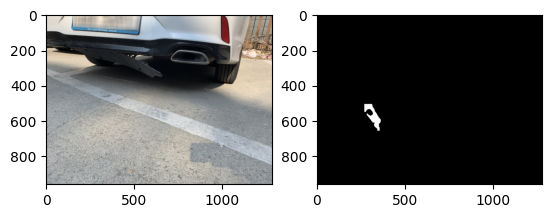

In [29]:
test_img = cv2.imread(test_file_list[1])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)[0]

result_mask = np.zeros(test_img.shape[:2])
masks = result.masks
masks

for m in masks:
    polygon_coord = m.xy[0]
    # 주어진 이미지 크기와 폴리곤 좌표를 사용하여 해당 영역을 1로 채운 마스크를 생성
    # 나머지는 0으로 유지
    mask = polygon2mask(test_img.shape[:2], polygon_coord)
    # maximum(): 두 배열의 요소별 최대값을 반환하므로 여러 객체의 마스크가 겹치더라도 최대값을 유지
    result_mask = np.maximum(mask, result_mask)
    # 2D 마스크를 3D 배열로 변환하고 repeat() 사용해 동일한 값을 3개의 채널에 복사
result_mask = np.repeat(result_mask[:, :, np.newaxis], 3, -1)

plt.subplot(1, 2, 1)
plt.imshow(img_src)
plt.subplot(1, 2, 2)
plt.imshow(result_mask)
plt.show()


0: 640x480 2 Scratcheds, 1 Crushed, 16.2ms
Speed: 3.0ms preprocess, 16.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


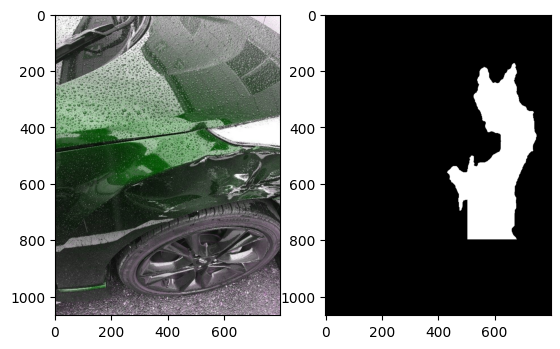

In [34]:
test_img = cv2.imread(test_file_list[3])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)[0]

result_mask = np.zeros(test_img.shape[:2])
masks = result.masks
masks

for m in masks:
    polygon_coord = m.xy[0]
    # 주어진 이미지 크기와 폴리곤 좌표를 사용하여 해당 영역을 1로 채운 마스크를 생성
    # 나머지는 0으로 유지
    mask = polygon2mask(test_img.shape[:2], polygon_coord)
    # maximum(): 두 배열의 요소별 최대값을 반환하므로 여러 객체의 마스크가 겹치더라도 최대값을 유지
    result_mask = np.maximum(mask, result_mask)
    # 2D 마스크를 3D 배열로 변환하고 repeat() 사용해 동일한 값을 3개의 채널에 복사
result_mask = np.repeat(result_mask[:, :, np.newaxis], 3, -1)

plt.subplot(1, 2, 1)
plt.imshow(img_src)
plt.subplot(1, 2, 2)
plt.imshow(result_mask)
plt.show()

Ultralytics YOLOv8.2.77 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8s-seg summary (fused): 195 layers, 11,781,148 parameters, 0 gradients, 42.4 GFLOPs


val: Scanning /content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation/cd/test/labels.cache... 229 images, 0 backgrounds, 0 corrupt: 100%|██████████| 229/229 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


                   all        229        765      0.154      0.156      0.086     0.0366      0.118      0.113     0.0522     0.0163
             Scratched        196        484      0.225      0.205      0.142     0.0534      0.206      0.169     0.0942     0.0257
              Breakage         77         99      0.131      0.111     0.0545     0.0242      0.112     0.0909     0.0392     0.0156
             Separated         71        107      0.176      0.243      0.126     0.0618      0.135      0.178     0.0729     0.0234
               Crushed         61         75     0.0838     0.0667     0.0218    0.00695     0.0177     0.0133    0.00252   0.000781
Speed: 5.2ms preprocess, 10.1ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/segment/val9

0: 640x480 2 Scratcheds, 1 Crushed, 16.2ms
Speed: 2.9ms preprocess, 16.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 480)


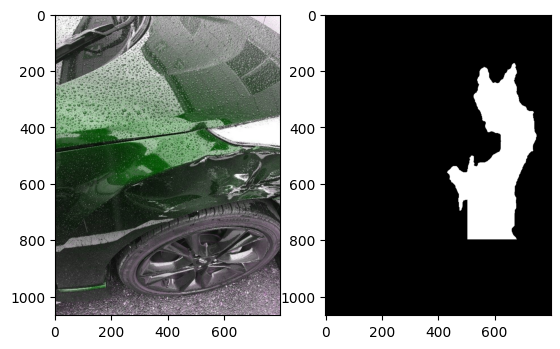

In [42]:
project_root = '/content/drive/MyDrive/KDT/8. 컴퓨터 비전/9. Segmentation'
result_floder = f'{project_root}/runs/segment'

model = YOLO(f'{result_floder}/yolo_s/weights/cd_pretrrained.pt')
metrics = model.val(split='test')

test_img = cv2.imread(test_file_list[3])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)[0]

result_mask = np.zeros(test_img.shape[:2])
masks = result.masks
masks

for m in masks:
    polygon_coord = m.xy[0]
    # 주어진 이미지 크기와 폴리곤 좌표를 사용하여 해당 영역을 1로 채운 마스크를 생성
    # 나머지는 0으로 유지
    mask = polygon2mask(test_img.shape[:2], polygon_coord)
    # maximum(): 두 배열의 요소별 최대값을 반환하므로 여러 객체의 마스크가 겹치더라도 최대값을 유지
    result_mask = np.maximum(mask, result_mask)
    # 2D 마스크를 3D 배열로 변환하고 repeat() 사용해 동일한 값을 3개의 채널에 복사
result_mask = np.repeat(result_mask[:, :, np.newaxis], 3, -1)

plt.subplot(1, 2, 1)
plt.imshow(img_src)
plt.subplot(1, 2, 2)
plt.imshow(result_mask)
plt.show()